##Exercise 5 - Part A: Cat vs. Dog Image Classification Using Dropout and Augmentation


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

## Exploring Data Augmentation


In [ ]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the [Keras documentation](https://keras.io/preprocessing/image/)). Let's quickly go over what we just wrote:

- `rotation_range` is a value in degrees (0–180), a range within which to randomly rotate pictures.
- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- `shear_range` is for randomly applying shearing transformations.
- `zoom_range` is for randomly zooming inside pictures.
- `horizontal_flip` is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images. First let's set up our example files, as in Exercise 1.


**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [ ]:
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip

--2022-05-23 13:27:46--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.45.112, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.45.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   158MB/s    in 0.4s    

2022-05-23 13:27:46 (158 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
  
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

Next, let's apply the `datagen` transformations to a cat image from the training set to produce five random variants. Rerun the cell a few times to see fresh batches of random variants.

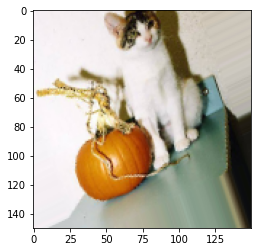

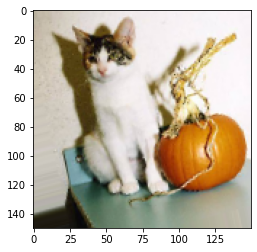

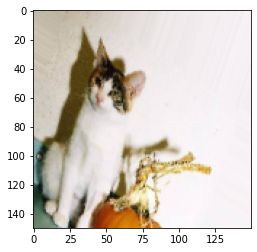

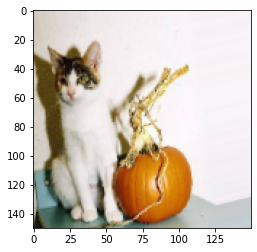

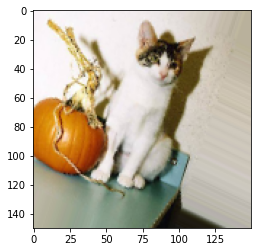

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

## Evaluate the Results

Function to evaluate the results of model training and print the accuracy:

In [ ]:
def evaluation(history):

  # Print accuracy
  print(('\033[1m' + 'Accuracy: ' + '\033[35m' + '{:.3f}' + '\033[44m' + '\033[0m' + '\n').format(history.history['val_acc'][-1]))  # The last value is the final validation accuracy

  # Plot training and validation loss
  fig, ax = plt.subplots()
  ax.plot(history.history["loss"], 'steelblue', label = "Train Loss")
  ax.plot(history.history["val_loss"], 'rosybrown', label = "Validation Loss")
  fig.suptitle('Training and Validation Loss', fontsize=16)
  ax.legend()

  # Plot training and validation accuracy
  fig, ax = plt.subplots()
  ax.plot(history.history['acc'], 'steelblue', label = "Train Accuracy")
  ax.plot(history.history['val_acc'],  'rosybrown', label = "Validation Accuracy")
  fig.suptitle('Training and Validation Accuracy', fontsize=16)
  ax.legend()

## **Model1 - Without Augmentation and Dropout**

In [ ]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B

model1 = keras.Sequential(
    [
        layers.Input(shape=(150, 150, 3)),
        # First convolution extracts 16 filters that are 3x3
        # Convolution is followed by max-pooling layer with a 2x2 window
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(2),
        # Second convolution extracts 32 filters that are 3x3
        # Convolution is followed by max-pooling layer with a 2x2 window
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(2),
        # Third convolution extracts 64 filters that are 3x3
        # Convolution is followed by max-pooling layer with a 2x2 window
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(2),
        # Flatten feature map to a 1-dim tensor so we can add fully connected layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid'),
    ]
)

model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 17, 17, 64)      

In [ ]:
model1.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model1.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/15
100/100 - 9s - loss: 0.8033 - acc: 0.5380 - val_loss: 0.6858 - val_acc: 0.5100 - 9s/epoch - 89ms/step
Epoch 2/15
100/100 - 8s - loss: 0.6421 - acc: 0.6575 - val_loss: 0.5990 - val_acc: 0.7070 - 8s/epoch - 80ms/step
Epoch 3/15
100/100 - 8s - loss: 0.5603 - acc: 0.7120 - val_loss: 0.5462 - val_acc: 0.7300 - 8s/epoch - 80ms/step
Epoch 4/15
100/100 - 8s - loss: 0.4695 - acc: 0.7835 - val_loss: 0.5754 - val_acc: 0.7240 - 8s/epoch - 80ms/step
Epoch 5/15
100/100 - 8s - loss: 0.3802 - acc: 0.8285 - val_loss: 0.6493 - val_acc: 0.7120 - 8s/epoch - 80ms/step
Epoch 6/15
100/100 - 8s - loss: 0.2996 - acc: 0.8700 - val_loss: 0.6380 - val_acc: 0.7190 - 8s/epoch - 79ms/step
Epoch 7/15
100/100 - 8s - loss: 0.2076 - acc: 0.9185 - val_loss: 0.8395 - val_acc: 0.7230 - 8s/epoch - 80ms/step
Epoch 8/15
100/100 - 8s - loss: 0.1377 - acc: 0.9450 - val_loss: 0.9817 - val_acc: 0.7050 - 8s/epoch - 81ms/step
Epoch 9/15
100/100 - 8s - loss: 0.1058 - acc: 0.9645 - val_loss: 1.0245 - val_acc: 0.7120 - 8s/e

Accuracy: 0.719



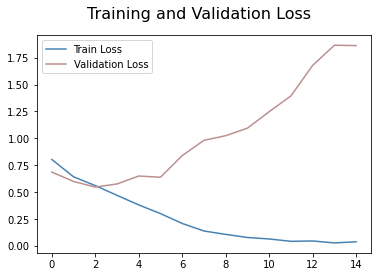

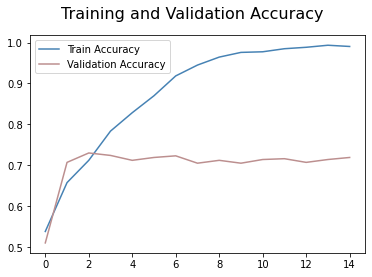

In [ ]:
evaluation(history)
accuracy1 = history.history['val_acc'][-1]

## **Model2 - With Dropout and Without Augmentation**

In [ ]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B

model2 = keras.Sequential(
    [
        layers.Input(shape=(150, 150, 3)),
        # First convolution extracts 16 filters that are 3x3
        # Convolution is followed by max-pooling layer with a 2x2 window
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(2),
        # Second convolution extracts 32 filters that are 3x3
        # Convolution is followed by max-pooling layer with a 2x2 window
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(2),
        # Third convolution extracts 64 filters that are 3x3
        # Convolution is followed by max-pooling layer with a 2x2 window
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(2),
        # Flatten feature map to a 1-dim tensor so we can add fully connected layers
        layers.Flatten(),
     
        layers.Dropout(0.5),  # Dropout!
     
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid'),
    ]
)

model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 17, 17, 64)      

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model2.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/15
100/100 - 9s - loss: 0.7599 - acc: 0.5315 - val_loss: 0.6472 - val_acc: 0.6760 - 9s/epoch - 88ms/step
Epoch 2/15
100/100 - 8s - loss: 0.6364 - acc: 0.6470 - val_loss: 0.5935 - val_acc: 0.6760 - 8s/epoch - 80ms/step
Epoch 3/15
100/100 - 8s - loss: 0.5568 - acc: 0.7160 - val_loss: 0.5486 - val_acc: 0.7240 - 8s/epoch - 80ms/step
Epoch 4/15
100/100 - 8s - loss: 0.5022 - acc: 0.7525 - val_loss: 0.5445 - val_acc: 0.7340 - 8s/epoch - 80ms/step
Epoch 5/15
100/100 - 8s - loss: 0.4379 - acc: 0.8015 - val_loss: 0.5737 - val_acc: 0.7350 - 8s/epoch - 80ms/step
Epoch 6/15
100/100 - 8s - loss: 0.3864 - acc: 0.8220 - val_loss: 0.5858 - val_acc: 0.7340 - 8s/epoch - 80ms/step
Epoch 7/15
100/100 - 8s - loss: 0.3445 - acc: 0.8475 - val_loss: 0.5815 - val_acc: 0.7320 - 8s/epoch - 80ms/step
Epoch 8/15
100/100 - 8s - loss: 0.2992 - acc: 0.8735 - val_loss: 0.5908 - val_acc: 0.7380 - 8s/epoch - 80ms/step
Epoch 9/15
100/100 - 8s - loss: 0.2502 - acc: 0.8995 - val_loss: 0.6727 - val_acc: 0.7330 - 8s/e

Accuracy: 0.736



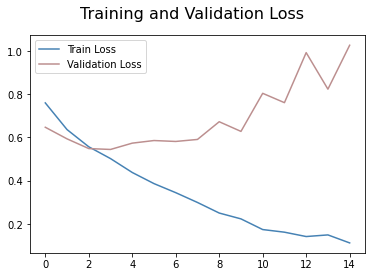

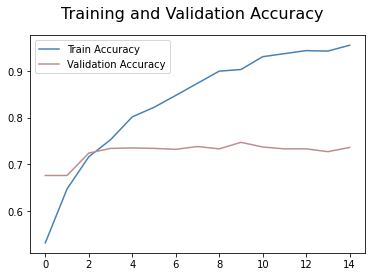

In [ ]:
evaluation(history)
accuracy2 = history.history['val_acc'][-1]

## **Model3 - With Augmentation and Without Dropout**


In [ ]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B

mode3 = keras.Sequential(
    [
        layers.Input(shape=(150, 150, 3)),
        # First convolution extracts 16 filters that are 3x3
        # Convolution is followed by max-pooling layer with a 2x2 window
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(2),
        # Second convolution extracts 32 filters that are 3x3
        # Convolution is followed by max-pooling layer with a 2x2 window
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(2),
        # Third convolution extracts 64 filters that are 3x3
        # Convolution is followed by max-pooling layer with a 2x2 window
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(2),
        # Flatten feature map to a 1-dim tensor so we can add fully connected layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid'),
    ]
)

mode3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 17, 17, 64)      

In [ ]:
mode3.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
history = mode3.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/15
100/100 - 17s - loss: 0.8307 - acc: 0.5495 - val_loss: 0.6783 - val_acc: 0.5350 - 17s/epoch - 170ms/step
Epoch 2/15
100/100 - 16s - loss: 0.6895 - acc: 0.5775 - val_loss: 0.6983 - val_acc: 0.5450 - 16s/epoch - 161ms/step
Epoch 3/15
100/100 - 16s - loss: 0.6597 - acc: 0.6285 - val_loss: 0.6721 - val_acc: 0.6220 - 16s/epoch - 161ms/step
Epoch 4/15
100/100 - 16s - loss: 0.6516 - acc: 0.6325 - val_loss: 0.6052 - val_acc: 0.6620 - 16s/epoch - 160ms/step
Epoch 5/15
100/100 - 16s - loss: 0.6424 - acc: 0.6490 - val_loss: 0.5986 - val_acc: 0.6650 - 16s/epoch - 163ms/step
Epoch 6/15
100/100 - 16s - loss: 0.6204 - acc: 0.6740 - val_loss: 0.5979 - val_acc: 0.6650 - 16s/epoch - 161ms/step
Epoch 7/15
100/100 - 16s - loss: 0.6114 - acc: 0.6770 - val_loss: 0.5768 - val_acc: 0.6900 - 16s/epoch - 160ms/step
Epoch 8/15
100/100 - 16s - loss: 0.6034 - acc: 0.6765 - val_loss: 0.6090 - val_acc: 0.6920 - 16s/epoch - 160ms/step
Epoch 9/15
100/100 - 16s - loss: 0.5940 - acc: 0.6870 - val_loss: 0.7044

Accuracy: 0.750



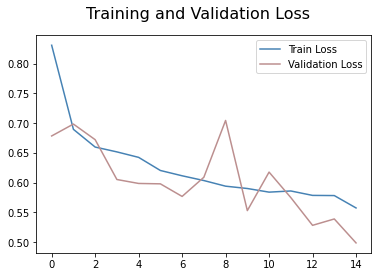

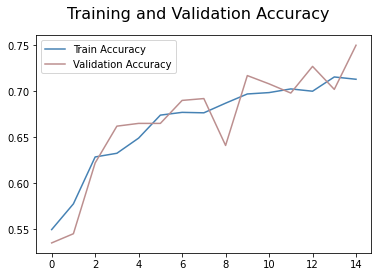

In [ ]:
evaluation(history)
accuracy3 = history.history['val_acc'][-1]

## **Model4 - With Both Dropout and Augmentation**

In [ ]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B

model4 = keras.Sequential(
    [
        layers.Input(shape=(150, 150, 3)),
        # First convolution extracts 16 filters that are 3x3
        # Convolution is followed by max-pooling layer with a 2x2 window
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(2),
        # Second convolution extracts 32 filters that are 3x3
        # Convolution is followed by max-pooling layer with a 2x2 window
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(2),
        # Third convolution extracts 64 filters that are 3x3
        # Convolution is followed by max-pooling layer with a 2x2 window
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(2),
        # Flatten feature map to a 1-dim tensor so we can add fully connected layers
        layers.Flatten(),
     
        layers.Dropout(0.5),  # Dropout!
     
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid'),
    ]
)

model4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 17, 17, 64)      

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
history = model4.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/15
100/100 - 17s - loss: 0.7934 - acc: 0.5225 - val_loss: 0.7001 - val_acc: 0.5020 - 17s/epoch - 174ms/step
Epoch 2/15
100/100 - 16s - loss: 0.6860 - acc: 0.5710 - val_loss: 0.6415 - val_acc: 0.6440 - 16s/epoch - 163ms/step
Epoch 3/15
100/100 - 17s - loss: 0.6741 - acc: 0.6280 - val_loss: 0.6704 - val_acc: 0.5700 - 17s/epoch - 170ms/step
Epoch 4/15
100/100 - 17s - loss: 0.6522 - acc: 0.6240 - val_loss: 0.5956 - val_acc: 0.6660 - 17s/epoch - 168ms/step
Epoch 5/15
100/100 - 16s - loss: 0.6305 - acc: 0.6400 - val_loss: 0.5726 - val_acc: 0.6830 - 16s/epoch - 164ms/step
Epoch 6/15
100/100 - 16s - loss: 0.6178 - acc: 0.6595 - val_loss: 0.5560 - val_acc: 0.7140 - 16s/epoch - 161ms/step
Epoch 7/15
100/100 - 16s - loss: 0.6161 - acc: 0.6680 - val_loss: 0.5945 - val_acc: 0.6630 - 16s/epoch - 163ms/step
Epoch 8/15
100/100 - 16s - loss: 0.6065 - acc: 0.6780 - val_loss: 0.5390 - val_acc: 0.7240 - 16s/epoch - 162ms/step
Epoch 9/15
100/100 - 16s - loss: 0.6037 - acc: 0.6815 - val_loss: 0.5686

Accuracy: 0.756



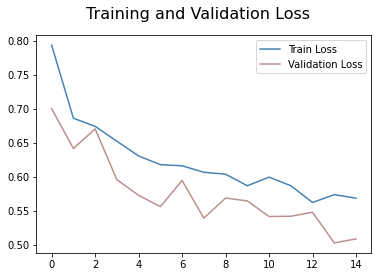

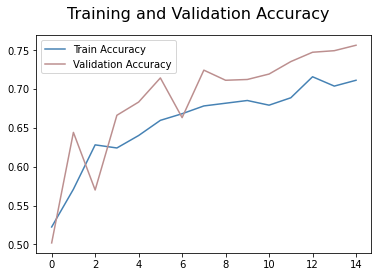

In [ ]:
evaluation(history)
accuracy4 = history.history['val_acc'][-1]

## **Conclusion**

In [ ]:
print(('\033[1m' + 'Without Augmentation and Dropout: ' + '\033[35m' + '{:.3f}' + '\033[44m' + '\033[0m' + '\n').format(accuracy1))
print(('\033[1m' + 'With Dropout and Without Augmentation: ' + '\033[35m' + '{:.3f}' + '\033[44m' + '\033[0m' + '\n').format(accuracy2))
print(('\033[1m' + 'With Augmentation and Without Dropout: ' + '\033[35m' + '{:.3f}' + '\033[44m' + '\033[0m' + '\n').format(accuracy3))
print(('\033[1m' + 'With Both Dropout and Augmentation: ' + '\033[35m' + '{:.3f}' + '\033[44m' + '\033[0m' + '\n').format(accuracy4))

Without Augmentation and Dropout: 0.719

With Dropout and Without Augmentation: 0.736

With Augmentation and Without Dropout: 0.750

With Both Dropout and Augmentation: 0.756



**Model with both Dropout and Augmentation gives the best accuracy.**